In [1]:
from gensim.test.utils import common_texts,get_tmpfile
from gensim.models import Word2Vec
import pandas as pd
import os
import jieba
import numpy as np
import logging
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn import manifold
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

In [2]:
#def normalize(data):
 #   data_normalized = (data - np.min(data))/ (np.max(data) - np.min(data))
  #  return data_normalized

In [3]:
# 读取文本语料
all_text = []
title = []
for root, dirs, files in os.walk("./data6", topdown=False):
    for name in files:
        if name[-4:] == ".txt":
            file_path = os.path.join(root, name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
                all_text.append("".join([line.strip() for line in lines]))
            title.append(name[:-4])

In [4]:
len(title)

176

In [5]:
# 建议分割文本
name = np.array(['嫦娥','后羿','牛郎','织女','田螺','玉兔','董永','仙女','法海','白素贞','小青','白娘子','许仙','梁山伯','祝英台'
                 ,'王母娘娘','沉香','二郎神','孙悟空','干将','莫邪','精卫','大禹','女娲','孟姜女','哪吒','夸父','花木兰','马良','杜康',
                '玉帝','伏羲','神农','柳毅','国王','西王母','尧','舜','皇帝','蚩尤','龙王','谢端','钟馗','狐狸','麻雀','喜鹊','燕子'
                 ,'鹿','董昭','韩湘子','玉皇大帝','太白金星','刘彦昌','仓颉','祝融','吴刚','老虎','神农','观音','鲤鱼','李文生','狐女','蛤蟆'])
for i in range(name.shape[0]):
    jieba.suggest_freq(name[i],True)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/sg/s3bw_m1s74z6wdlxtk_24cf00000gn/T/jieba.cache
Loading model cost 0.617 seconds.
Prefix dict has been built successfully.


In [6]:
# 过滤文本
segment_text = [list(jieba.cut(line)) for line in all_text]
punc = set("！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.,.;。")
segment_text_no_punc = [[word for word in line if not word in punc] for line in segment_text]

In [7]:
#　删除停用词
def read_file(filename):
    with  open(filename, 'r',encoding='utf-8')as f:
        text = f.read()
        #返回list类型数据
        text = text.split('\n')
    return text

#去停用词函数
def del_stopwords(words):
    # 读取停用词表
    stopwords = read_file(r"stopwords.txt")
    # 去除停用词后的句子
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

segment_text_no_punc_ = []
for i in range(len(segment_text_no_punc)):
    segment_text_no_punc_.append(del_stopwords(segment_text_no_punc[i]))

In [8]:
# 封装训练语料库
documents = [TaggedDocument(segment_text_no_punc_[i], title[i]) for i in range(len(segment_text_no_punc_))]

In [9]:
# 构建DBOW模型
model_dbow = Doc2Vec(documents, dm=1, min_count=1, window=5, vector_size=500, sample=1e-3, negative=5) 
# 训练
model_dbow.train(documents, total_examples=model_dbow.corpus_count, epochs=30)

In [10]:
model_dbow.save('model_dbow.m')

In [11]:
# 构建DM模型
model_dmm = Doc2Vec(documents, dm=0, min_count=1, window=5, vector_size=500, sample=1e-3, negative=5) 
# 训练
model_dmm.train(documents, total_examples=model_dmm.corpus_count, epochs=30)

In [12]:
model_dmm.save('model_dmm.m')

In [13]:
# 合成构建模型
model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [14]:
# 获取文档的向量表示
segment_text_no_punc_vector = np.array([model.infer_vector(i) for i in segment_text_no_punc_])

In [ ]:
# 计算相似度
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances

def mashi_distance(x,y):
    X=np.vstack([x,y])
    XT=X.T
    S=np.cov(X)  #两个维度之间协方差矩阵
    SI = np.linalg.inv(S) #协方差矩阵的逆矩阵
    n=XT.shape[0]
    d1=[]
    for i in range(0,n):
        for j in range(i+1,n):
            delta=XT[i]-XT[j]
        d=np.sqrt(np.dot(np.dot(delta,SI),delta.T))
        d1.append(d)
    return np.sqrt(np.sum(d1))

def cal_cosine_similarity(name1,name2,vector,names):
    index1 = -1
    index2 = -1
    for i in range(len(names)):
        if name1 == names[i]:
            index1 = i
            break
    if index1 == -1:
        print('故事文档不存在')
    for i in range(len(names)):
        if name2 == names[i]:
            index2 = i
            break
    if index2 == -1:
        print('故事文档不存在')
#    return ('"The similarity between {}" and "{}" is:{}'.format(name1,name2,np.average(np.average(cosine_similarity(np.array([vector[index1],vector[index2]])),axis=0))), \
#            '"The euclidean distances between {}" and "{}" is:{}'.format(name1,name2,np.average(np.average(euclidean_distances(np.array([vector[index1],vector[index2]])),axis=0))),
#            '"The mashi distances between {}" and "{}" is:{}'.format(name1,name2, mashi_distance(np.asarray(vector[index1]),np.asarray(vector[index2]))))
    return np.average(np.average(cosine_similarity(np.array([vector[index1],vector[index2]])),axis=0)),np.average(np.average(euclidean_distances(np.array([vector[index1],vector[index2]])),axis=0)),mashi_distance(np.asarray(vector[index1]),np.asarray(vector[index2]))

In [21]:
print(cal_cosine_similarity('农夫与蛇','东郭先生与狼',segment_text_no_punc_vector,title))



NameError: name 'cal_cosine_similarity' is not defined

In [ ]:
import pandas as pd

result_cosine = pd.DataFrame(index=title,columns=title)
result_euclidean = pd.DataFrame(index=title,columns=title)
result_mashi = pd.DataFrame(index=title,columns=title)
length = len(title)
for i in range(length): 
    for j in range(length): 
        if i == j:
            result_cosine.loc[title[i], title[j]] = 1
            result_euclidean.loc[title[i], title[j]] = 0
            result_mashi.loc[title[i], title[j]] = 0
        else:
            result = cal_cosine_similarity(title[i],title[j],segment_text_no_punc_vector,title)
            print(title[i],title[j],result)
            result_cosine.loc[title[i], title[j]] = result[0]
            result_euclidean.loc[title[i], title[j]] = result[1]
            result_mashi.loc[title[i], title[j]] = result[2]

In [61]:
result_cosine

,嫘祖的传说故事,狼来了,涌泉宝珠,仙女造桥,女娲造人,龙外孙的故事,蚁王报恩的故事,月下老人,煮海治龙王,龙之九子,...,会吃金子的老鼠,棘刺尖雕猴子,井神的传说,雷泽华胥,陶神的故事,玉兔望月,吴梦举遇仙,庖丁解牛,李良审鹅,观音送画
嫘祖的传说故事,1,0.56474,0.599689,0.695758,0.712736,0.780037,0.790764,0.628215,0.654974,0.636688,...,0.755614,0.679129,0.900676,0.797726,0.886293,0.695708,0.613661,0.707286,0.51506,0.662936
狼来了,0.56474,1,0.636406,0.689079,0.682772,0.580748,0.630656,0.739238,0.585416,0.606259,...,0.774374,0.683138,0.621217,0.71125,0.569051,0.647543,0.689881,0.720004,0.701602,0.729634
涌泉宝珠,0.599689,0.636406,1,0.676164,0.628497,0.587142,0.604093,0.677687,0.626787,0.628053,...,0.673978,0.701703,0.670432,0.743287,0.587008,0.677737,0.706752,0.655114,0.69121,0.749248
仙女造桥,0.695758,0.689079,0.676164,1,0.832383,0.703916,0.699748,0.658645,0.686021,0.639011,...,0.683309,0.615889,0.719345,0.796516,0.735408,0.698648,0.771141,0.794503,0.66148,0.805094
女娲造人,0.712736,0.682772,0.628497,0.832383,1,0.721884,0.683063,0.756619,0.618764,0.634943,...,0.670286,0.582554,0.748428,0.801466,0.730929,0.641238,0.574293,0.790604,0.584597,0.77328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
玉兔望月,0.695708,0.647543,0.677737,0.698648,0.641238,0.612834,0.690926,0.811848,0.639026,0.624282,...,0.652921,0.669829,0.701159,0.726507,0.665086,1,0.640348,0.699372,0.615782,0.692403
吴梦举遇仙,0.613661,0.689881,0.706752,0.771141,0.574293,0.550822,0.561359,0.65743,0.586234,0.621474,...,0.713262,0.715403,0.662489,0.723715,0.612506,0.640348,1,0.624569,0.698243,0.70307
庖丁解牛,0.707286,0.720004,0.655114,0.794503,0.790604,0.6731,0.724925,0.746454,0.659436,0.689269,...,0.771893,0.759003,0.696512,0.81745,0.692694,0.699372,0.624569,1,0.62939,0.771162
李良审鹅,0.51506,0.701602,0.69121,0.66148,0.584597,0.60406,0.576529,0.643006,0.672004,0.634972,...,0.659318,0.666629,0.597361,0.724232,0.566624,0.615782,0.698243,0.62939,1,0.749543


In [62]:
result_cosine.to_csv('wildcard6.csv')

In [63]:
result_mashi.to_csv('ms6.csv')

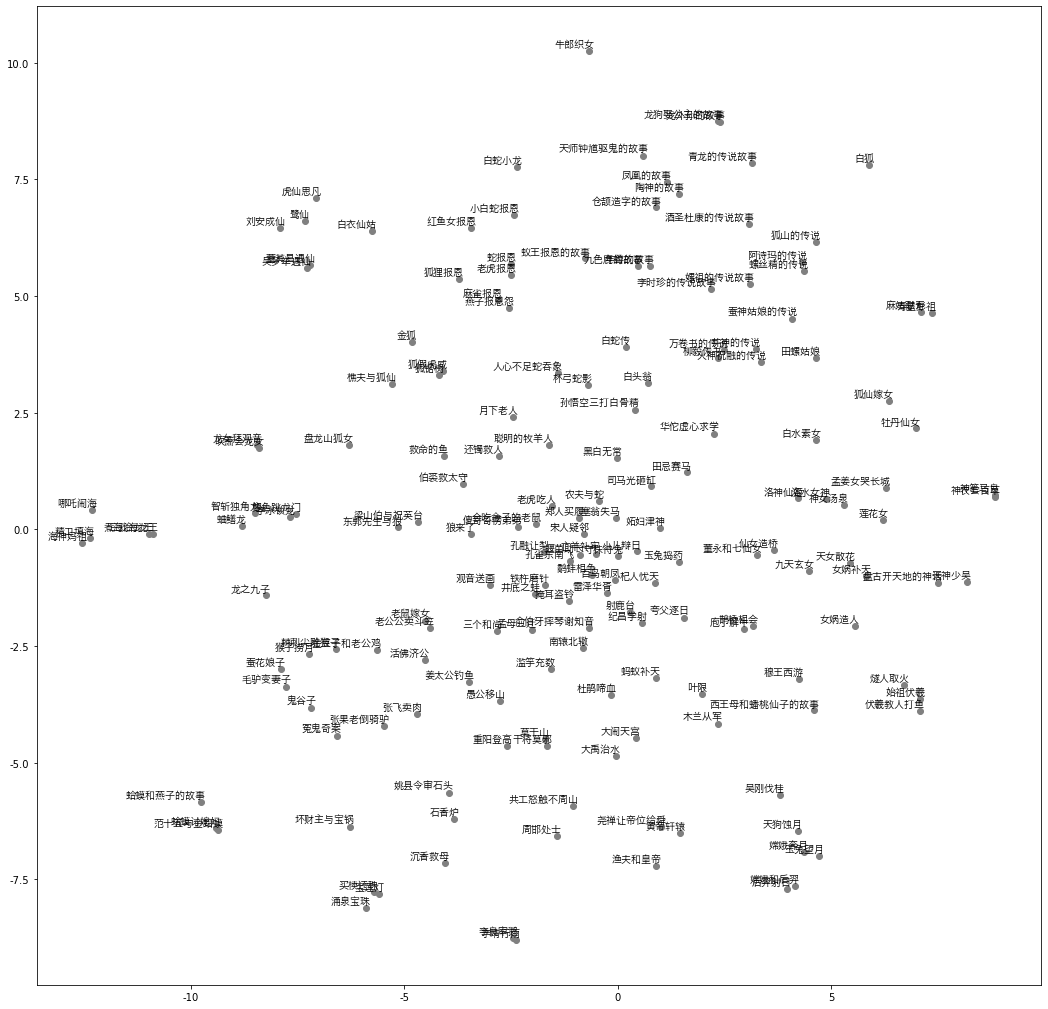

In [23]:
# 可视化模型结果
%matplotlib inline
def plot_with_labels(low_dim_embs, labels):
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['SimHei']
    rcParams['axes.unicode_minus'] = False
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    myfont = font_manager.FontProperties(fname='/System/Library/Fonts/Hiragino Sans GB.ttc')
    plt.figure(figsize=(18, 18)) 
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, color = 'gray')
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',fontproperties=myfont)
    plt.show()

# 降维可视化聚类
from sklearn.manifold import TSNE

tsne = TSNE()
low_dim_embedding = tsne.fit_transform(segment_text_no_punc_vector)
plot_with_labels(low_dim_embedding, title)

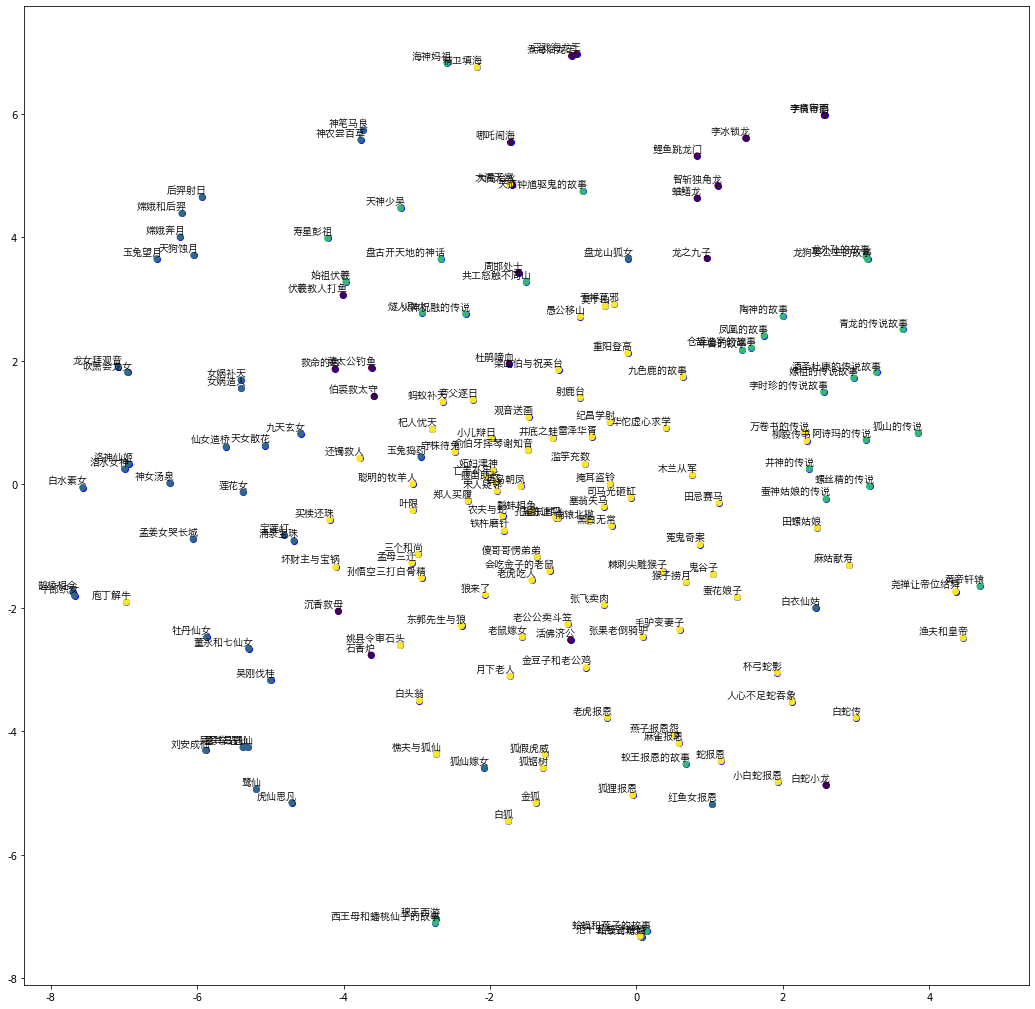

In [428]:
# 文本聚类可视化
from sklearn.cluster import KMeans

%matplotlib inline
def plot_with_labels2(low_dim_embs, title, labels):
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['SimHei']
    rcParams['axes.unicode_minus'] = False
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    myfont = font_manager.FontProperties(fname='/System/Library/Fonts/Hiragino Sans GB.ttc')
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, c = 'blue')
        plt.annotate(title[i],xy=(x, y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom',fontproperties=myfont)
    low_dim_embs = np.array(low_dim_embs)
    plt.scatter(low_dim_embs[:,0],low_dim_embs[:,1], c = labels)
    plt.show()

    
kmeans_model = KMeans(n_clusters = 4, n_jobs = 1, max_iter = 1000)
kmeans_model.fit(segment_text_no_punc_vector_norm)
labels = kmeans_model.labels_.tolist()
tsne = TSNE()
low_dim_embedding = tsne.fit_transform(segment_text_no_punc_vector_norm)
plot_with_labels2(low_dim_embedding,title, labels)

In [33]:
# 读取文本语料
all_text = []
title = []
for root, dirs, files in os.walk("./data3", topdown=False):
    for name in files:
        if name[-4:] == ".txt":
            file_path = os.path.join(root, name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
                all_text.append("".join([line.strip() for line in lines]))
            title.append(name[:-4])

In [34]:
len(title)

176

In [35]:
# 过滤文本
segment_text = [list(jieba.cut(line)) for line in all_text]
punc = set("！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.,.;。")
segment_text_no_punc = [[word for word in line if not word in punc] for line in segment_text]

In [36]:
#　删除停用词
def read_file(filename):
    with  open(filename, 'r',encoding='utf-8')as f:
        text = f.read()
        #返回list类型数据
        text = text.split('\n')
    return text

#去停用词函数
def del_stopwords(words):
    # 读取停用词表
    stopwords = read_file(r"stopwords.txt")
    # 去除停用词后的句子
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

segment_text_no_punc_ = []
for i in range(len(segment_text_no_punc)):
    segment_text_no_punc_.append(del_stopwords(segment_text_no_punc[i]))

In [37]:
# 封装训练语料库
documents = [TaggedDocument(segment_text_no_punc_[i], title[i]) for i in range(len(segment_text_no_punc_))]

In [38]:
model_dbow = Doc2Vec.load('model_dbow.m')
model_dbow.train(documents, total_examples=model_dbow.corpus_count, epochs=30)

In [39]:
model_dmm = Doc2Vec.load('model_dmm.m')
model_dmm.train(documents, total_examples=model_dmm.corpus_count, epochs=30)

In [40]:
# 合成构建模型
model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [41]:
# 获取文档的向量表示
segment_text_no_punc_vector = np.array([model.infer_vector(i) for i in segment_text_no_punc_])

In [42]:
# 文档向量归一化
#from sklearn.preprocessing import MinMaxScaler
#segment_text_no_punc_vector_norm = normalize(segment_text_no_punc_vector)

In [43]:
# 降维可视化聚类, 可视化模型结果
%matplotlib inline
tsne = TSNE()
low_dim_embedding = tsne.fit_transform(segment_text_no_punc_vector_norm)
plot_with_labels(low_dim_embedding, title)

NameError: name 'TSNE' is not defined

In [44]:
# 文本聚类可视化
%matplotlib inline
kmeans_model = KMeans(n_clusters = 10, n_jobs = 1, max_iter = 1000)
kmeans_model.fit(segment_text_no_punc_vector_norm)
labels = kmeans_model.labels_.tolist()
tsne = TSNE()
low_dim_embedding = tsne.fit_transform(segment_text_no_punc_vector_norm)
plot_with_labels2(low_dim_embedding,title, labels)

NameError: name 'KMeans' is not defined

In [45]:
import pandas as pd
import numpy as np

result_cosine = pd.DataFrame(index=title,columns=title)
result_euclidean = pd.DataFrame(index=title,columns=title)
result_mashi = pd.DataFrame(index=title,columns=title)
length = len(title)
for i in range(length): 
    for j in range(length): 
        if i == j:
            result_cosine.loc[title[i], title[j]] = 1
            result_euclidean.loc[title[i], title[j]] = 0
            result_mashi.loc[title[i], title[j]] = 0
        else:
            result = cal_cosine_similarity(title[i],title[j],segment_text_no_punc_vector,title)
            print(title[i],title[j],result)
            result_cosine.loc[title[i], title[j]] = result[0]
            
            result_euclidean.loc[title[i], title[j]] = result[1]
            result_mashi.loc[title[i], title[j]] = result[2]

嫘祖的传说故事 狼来了 (0.6084719, 15.82242, 38.439083858557126)
嫘祖的传说故事 涌泉宝珠 (0.62291014, 22.177917, 36.854492017499986)
嫘祖的传说故事 仙女造桥 (0.72082937, 14.368868, 36.56411230800275)
嫘祖的传说故事 女娲造人 (0.68130994, 17.310495, 37.70483532575253)
嫘祖的传说故事 龙外孙的故事 (0.7324322, 19.284937, 40.40155806103628)
嫘祖的传说故事 蚁王报恩的故事 (0.7651427, 14.30021, 41.31552587188494)
嫘祖的传说故事 月下老人 (0.62799823, 20.054941, 36.54950618398867)
嫘祖的传说故事 煮海治龙王 (0.6620859, 20.945042, 35.2745758029723)
嫘祖的传说故事 龙之九子 (0.6157293, 21.16724, 35.84314162491777)
嫘祖的传说故事 聪明的牧羊人 (0.71202517, 14.976012, 40.35845110668107)
嫘祖的传说故事 年兽的故事 (0.80318403, 12.332453, 37.40992575226948)
嫘祖的传说故事 麻雀报恩 (0.6409056, 16.978973, 35.819484561214765)
嫘祖的传说故事 红鱼女报恩 (0.6345465, 23.618952, 35.513703059581395)
嫘祖的传说故事 鲤鱼跳龙门 (0.621534, 19.265179, 35.79998595138635)
嫘祖的传说故事 嫦娥和后羿 (0.5947307, 21.394087, 35.8410451451904)
嫘祖的传说故事 狐山的传说 (0.77956104, 15.802793, 35.631254272481065)
嫘祖的传说故事 精卫填海 (0.6726334, 18.714767, 37.28362417078884)
嫘祖的传说故事 李冰锁龙 (0.6203192, 23.600584, 36.90177239

KeyboardInterrupt: 

In [522]:
# 结果归一化
from sklearn.preprocessing import MinMaxScaler
result_cosine_norm = pd.DataFrame(MinMaxScaler().fit_transform(result_cosine.values),index=title,columns=title)
print('cosine Normalized',result_cosine_norm.head(10),sep='\n')
#result_euclidean_norm = pd.DataFrame(MinMaxScaler().fit_transform(result_euclidean.values),index=title,columns=title)
#print('euclidean Normalized',result_euclidean_norm.head(10),sep='\n')
#result_mashi_norm = pd.DataFrame(MinMaxScaler().fit_transform(result_mashi.values),index=title,columns=title)
#print('mashi Normalized',result_mashi_norm.head(10),sep='\n')

cosine Normalized
          嫘祖的传说故事       狼来了      涌泉宝珠      仙女造桥      女娲造人    龙外孙的故事   蚁王报恩的故事  \
嫘祖的传说故事  1.000000  0.690261  0.472050  0.703972  0.651892  0.636461  0.750845   
狼来了      0.690373  1.000000  0.576392  0.840757  0.767462  0.582755  0.775060   
涌泉宝珠     0.397705  0.516567  1.000000  0.456354  0.417061  0.332031  0.410651   
仙女造桥     0.745143  0.862856  0.589736  1.000000  0.834691  0.646836  0.761086   
女娲造人     0.635266  0.756268  0.464611  0.798815  1.000000  0.600642  0.621471   
龙外孙的故事   0.543634  0.476027  0.264975  0.485037  0.521521  1.000000  0.602488   
蚁王报恩的故事  0.754671  0.778435  0.491331  0.726751  0.644273  0.688207  1.000000   
月下老人     0.513962  0.696353  0.431843  0.595197  0.695780  0.349277  0.542654   
煮海治龙王    0.466566  0.506283  0.355779  0.478703  0.401438  0.639204  0.573141   
龙之九子     0.465744  0.576360  0.362543  0.511144  0.514251  0.635760  0.525476   

             月下老人     煮海治龙王      龙之九子  ...   会吃金子的老鼠    棘刺尖雕猴子     井神的传说  \
嫘祖的传说故事  0.560

In [523]:
print(cal_cosine_similarity('农夫与蛇','东郭先生与狼',segment_text_no_punc_vector_norm,title))




(0.99756414, 0.76991695, 34.40166392886173)


In [192]:
result_cosine_norm

,嫘祖的传说故事,狼来了,涌泉宝珠,仙女造桥,女娲造人,龙外孙的故事,蚁王报恩的故事,月下老人,煮海治龙王,龙之九子,...,会吃金子的老鼠,棘刺尖雕猴子,井神的传说,雷泽华胥,陶神的故事,玉兔望月,吴梦举遇仙,庖丁解牛,李良审鹅,观音送画
嫘祖的传说故事,1.000000,0.000000,0.000000,0.090000,0.160616,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
狼来了,0.028742,1.000000,0.125847,0.037270,0.183783,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
涌泉宝珠,0.000000,0.099978,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
仙女造桥,0.308263,0.246525,0.239850,1.000000,0.509781,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
女娲造人,0.266811,0.265949,0.126515,0.436692,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
玉兔望月,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
吴梦举遇仙,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
庖丁解牛,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
李良审鹅,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
result_cosine.to_csv('wildcard3.csv')

In [205]:
result_mashi.to_csv('ms3.csv')

In [206]:
result_cosine

,嫘祖的传说故事,狼来了,涌泉宝珠,仙女造桥,女娲造人,龙外孙的故事,蚁王报恩的故事,月下老人,煮海治龙王,龙之九子,...,会吃金子的老鼠,棘刺尖雕猴子,井神的传说,雷泽华胥,陶神的故事,玉兔望月,吴梦举遇仙,庖丁解牛,李良审鹅,观音送画
嫘祖的传说故事,1,0.623094,0.615021,0.725507,0.680465,0.736314,0.768334,0.627952,0.669816,0.635582,...,0.782708,0.658641,0.839993,0.784403,0.80655,0.67504,0.589688,0.687198,0.555019,0.655717
狼来了,0.623094,1,0.625529,0.708852,0.719602,0.631451,0.656869,0.718534,0.599411,0.623743,...,0.779091,0.641312,0.666433,0.701184,0.639657,0.66748,0.702327,0.717323,0.687907,0.694781
涌泉宝珠,0.615021,0.625529,1,0.672324,0.624221,0.602193,0.607518,0.63165,0.636876,0.62069,...,0.676119,0.677365,0.657673,0.72805,0.613328,0.648401,0.712792,0.65148,0.688186,0.730337
仙女造桥,0.725507,0.708852,0.672324,1,0.815484,0.719932,0.694805,0.666685,0.681535,0.644401,...,0.729967,0.582055,0.716075,0.787047,0.721041,0.698315,0.712062,0.750389,0.677064,0.706826
女娲造人,0.680465,0.719602,0.624221,0.815484,1,0.710689,0.644707,0.753088,0.590763,0.631952,...,0.69896,0.568531,0.701206,0.783414,0.697191,0.612302,0.564677,0.720509,0.635687,0.702043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
玉兔望月,0.67504,0.66748,0.648401,0.698315,0.612302,0.622345,0.699857,0.820569,0.63794,0.621569,...,0.698457,0.635096,0.694748,0.715682,0.647568,1,0.613159,0.665978,0.644186,0.648952
吴梦举遇仙,0.589688,0.702327,0.712792,0.712062,0.564677,0.575923,0.547908,0.640516,0.610951,0.646101,...,0.707308,0.674285,0.623167,0.665374,0.583738,0.613159,1,0.592523,0.655896,0.655158
庖丁解牛,0.687198,0.717323,0.65148,0.750389,0.720509,0.640723,0.693714,0.701009,0.64395,0.68947,...,0.780271,0.747752,0.637372,0.773292,0.646331,0.665978,0.592523,1,0.633388,0.670596
李良审鹅,0.555019,0.687907,0.688186,0.677064,0.635687,0.636078,0.602564,0.658506,0.661394,0.622779,...,0.669541,0.630882,0.632136,0.717974,0.62978,0.644186,0.655896,0.633388,1,0.692417
